# Data Analysis with MCMC

Here we use MCMC to sample the posterior probability distribution for a simple model, fitting y = f(x; theta)

#### Begin with relevant imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#### Define the model function, and generate some fake data to fit

Here `func()` is our model function, a simple quadratic representing the height of a falling object as a function of time. The independent variable `x` is the time, the parameters `h0`, `v0`, and `g` are the initial height, velocity, and acceleration due to gravity.

`genData()` generates `N` datapoints evenly sampled in time with independent Gaussian errors (of amplitude `sig`).

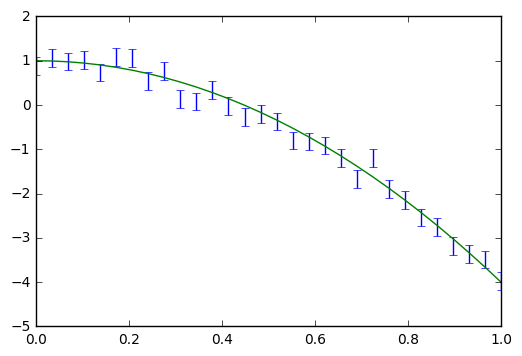

In [46]:
def func(x, h0, v0, g):
    return h0 + v0*x + 0.5*g*x*x

def genData(N, h0, v0, g, sig):
    x = np.linspace(0,1,N)
    y = func(x, h0, v0, g)
    yerr = np.empty(N)
    yerr[:] = sig
    r = np.random.randn(N)
    y[:] += yerr*r
    
    return x, y, yerr
    
h0 = 1
v0 = 0
g = -10
x, y, yerr = genData(30, 1, 0, -10, 0.2)

#Plot the data we just made
fig, ax = plt.subplots(1,1)
ax.errorbar(x, y, yerr, ls='')
ax.plot(x, func(x, h0, v0, g))

#### Sampling the posterior

The arrays `x`, `y`, and `yerr` are our data.  Now we forget we know the "true" values, and try to determine them probabalistically.  First we import the MCMC package `emcee`, then we define `logprob`, the logarithm of the posterior probability distribution.  In our simple model the uncertainties `yerr` are independent and gaussian, so the Likelihood is a simple chi2.  We assume flat priors for now.

Once the functions are defined, we create a Sampler object, create an array of random initial positions for the walkers, and run the MCMC.

In [56]:
import emcee

def logprob(theta, x, y, yerr):
    ymodel = func(x, *theta)
    chi2 = (((y-ymodel)/yerr)**2).sum()
    logprior = 0.0
    return logprior + -0.5*chi2

nwalkers = 100
ndim = 3
niterations = 2000
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, 
                                args=[x,y,yerr])

p0 = [np.random.rand(3) for i in range(nwalkers)]

sampler_out = sampler.run_mcmc(p0, niterations)

#### Sampling is done!  

The Sampler object contains two important views on the samples. `chain` has size [nwalkers, niterations, ndim] while `flatchain` has size [nwalkers * niterations, ndim].  They are the same data, just arranged differently.

In [57]:
chain = sampler.chain
samples = sampler.flatchain
print(chain.shape)
print(samples.shape)

(100, 2000, 3)
(200000, 3)


### Viewing the model realizations

Here we plot the data against the realizations for each one of the walkers in the last iteration.  This gives an idea of the distributions of possible curves.

<Container object of 3 artists>

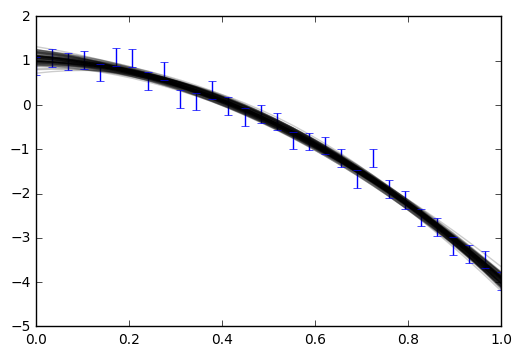

In [58]:
fig, ax = plt.subplots(1,1)

for theta in chain[:,-1]:
    ax.plot(x, func(x, *theta), alpha=0.2, color='k')
ax.errorbar(x, y, yerr, ls='')

### Viewing the Posterior

We can use the `corner` package to view the distributions of each parameter and all the pairwise correlations in a very nice looking plot.  

When we use all the samples, the distributions look very strange. This is because the initial condition was very far from the true values, it took several iterations for the walkers to reach the correct region of phase space.

`samplesTrimmed` takes the original chain, cuts out the first half of the iterations, and flattens the result.  The corner plot with these samples is more appropriate, the initial condition has been forgotten. The initial evolution of an MCMC chain is called the "burn-in" phase and is usually discarded.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


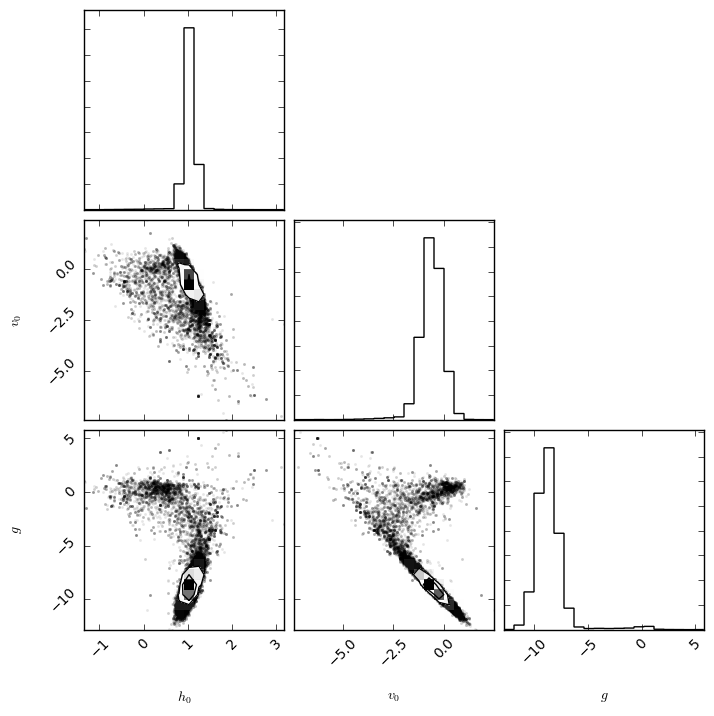

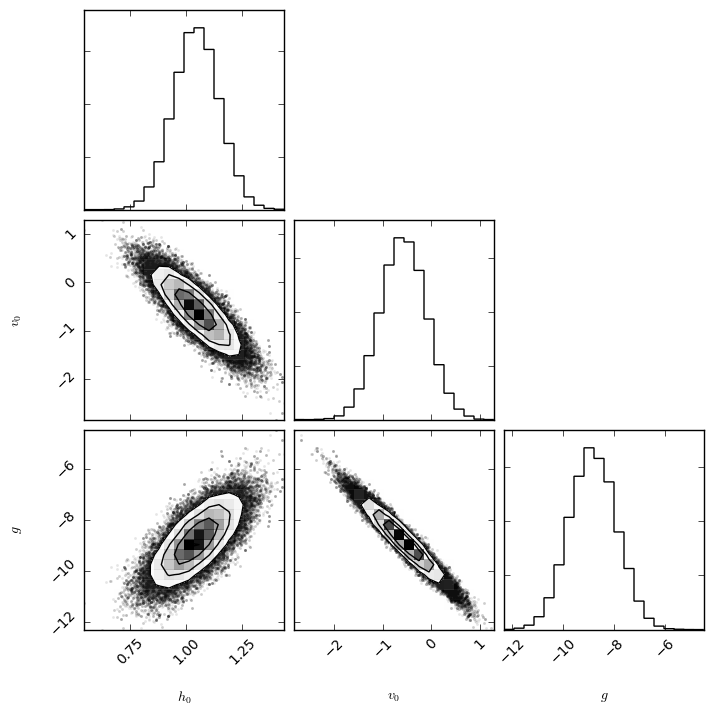

In [59]:
import corner

fig = corner.corner(samples, labels=[r"$h_0$", r"$v_0$", r"$g$"])

samplesTrimmed = np.resize(chain[:,niterations/2:,:], (-1,3))
fig2 = corner.corner(samplesTrimmed, labels=[r"$h_0$", r"$v_0$", r"$g$"])

## Finally, parameter estimates!

Now we can finally calculate estimates for each parameter.  We will use standard expected values, although for non-gaussian distributions reporting quantiles can be more appropriate.

In [61]:
avg_h0 = samples[:,0].mean()
avg_v0 = samples[:,1].mean()
avg_g = samples[:,2].mean()

avg_h02 = (samples[:,0]**2).mean()
avg_v02 = (samples[:,1]**2).mean()
avg_g2 = (samples[:,2]**2).mean()

sig_h0 = np.sqrt(avg_h02 - avg_h0**2)
sig_v0 = np.sqrt(avg_v02 - avg_v0**2)
sig_g = np.sqrt(avg_g2 - avg_g**2)

print("h0: {0:.2f} +/- {1:.2f}".format(avg_h0, sig_h0))
print("v0: {0:.2f} +/- {1:.2f}".format(avg_v0, sig_v0))
print("g:  {0:.2f} +/- {1:.2f}".format(avg_g, sig_g))

h0: 1.04 +/- 0.16
v0: -0.63 +/- 0.57
g:  -8.57 +/- 1.57


# Not Too Bad!